In [139]:
import sys
import pandas as pd
import numpy as np
sys.path.append('../ift6758/data/')
from get_data import get_games_data

In [140]:
train_2015_2018 = pd.read_csv('./milestone2_csvs/tidy_train_2015_2018.csv')

In [141]:
test_2019_2020 = pd.read_csv('./milestone2_csvs/tidy_test_2019_2020.csv')

In [142]:
train_2015_2018.head()

,event_idx,period_time,period,game_id,team_away_name,team_home_name,is_goal,coordinate_x,coordinate_y,shot_type,strength,shooter_name,goalie_name,empty_net,team_name,distance,angle
0,7,00:51,1,2015020001,Montréal Canadiens,Toronto Maple Leafs,0,-55.0,6.0,Wrist Shot,NaN,Brad Boyes,Brad Boyes,0,Toronto Maple Leafs,34.5254,0.1087
1,9,01:05,1,2015020001,Montréal Canadiens,Toronto Maple Leafs,0,-79.0,0.0,Snap Shot,NaN,Nazem Kadri,Nazem Kadri,0,Toronto Maple Leafs,10.0000,0.0000
2,10,01:06,1,2015020001,Montréal Canadiens,Toronto Maple Leafs,0,-75.0,-1.0,Snap Shot,NaN,Nazem Kadri,Nazem Kadri,0,Toronto Maple Leafs,14.0357,0.0133
3,13,01:53,1,2015020001,Montréal Canadiens,Toronto Maple Leafs,0,-55.0,-36.0,Wrist Shot,NaN,Daniel Winnik,Daniel Winnik,0,Toronto Maple Leafs,49.5177,0.5796
4,21,02:37,1,2015020001,Montréal Canadiens,Toronto Maple Leafs,0,-61.0,-1.0,Tip-In,NaN,Joffrey Lupul,Joffrey Lupul,0,Toronto Maple Leafs,28.0179,0.0164


In [143]:
train_2015_2018.tail()

,event_idx,period_time,period,game_id,team_away_name,team_home_name,is_goal,coordinate_x,coordinate_y,shot_type,strength,shooter_name,goalie_name,empty_net,team_name,distance,angle
332737,276,15:22,3,2018030417,St. Louis Blues,Boston Bruins,1,-77.0,7.0,Snap Shot,Even,Zach Sanford,Zach Sanford,0,St. Louis Blues,13.8924,0.0907
332738,279,15:51,3,2018030417,St. Louis Blues,Boston Bruins,0,-69.0,7.0,Snap Shot,NaN,Alexander Steen,Alexander Steen,0,St. Louis Blues,21.1896,0.1011
332739,280,15:55,3,2018030417,St. Louis Blues,Boston Bruins,0,-65.0,-4.0,Snap Shot,NaN,Ryan O'Reilly,Ryan O'Reilly,0,St. Louis Blues,24.3311,0.0615
332740,284,16:50,3,2018030417,St. Louis Blues,Boston Bruins,0,42.0,3.0,Wrist Shot,NaN,Marcus Johansson,Marcus Johansson,0,Boston Bruins,47.0956,0.0713
332741,289,17:50,3,2018030417,St. Louis Blues,Boston Bruins,1,44.0,24.0,Wrist Shot,Even,Matt Grzelcyk,Matt Grzelcyk,0,Boston Bruins,51.0000,0.4993


In [144]:
test_2019_2020.head()

,event_idx,period_time,period,game_id,team_away_name,team_home_name,is_goal,coordinate_x,coordinate_y,shot_type,strength,shooter_name,goalie_name,empty_net,team_name,distance,angle
0,4,00:25,1,2019020001,Ottawa Senators,Toronto Maple Leafs,1,85.0,-1.0,Tip-In,Even,Brady Tkachuk,Brady Tkachuk,0,Ottawa Senators,4.1231,0.0118
1,12,01:31,1,2019020001,Ottawa Senators,Toronto Maple Leafs,0,-32.0,-2.0,Snap Shot,NaN,Morgan Rielly,Morgan Rielly,0,Toronto Maple Leafs,57.0351,0.0624
2,19,03:23,1,2019020001,Ottawa Senators,Toronto Maple Leafs,0,63.0,-6.0,Snap Shot,NaN,Dylan DeMelo,Dylan DeMelo,0,Ottawa Senators,26.6833,0.0950
3,22,03:56,1,2019020001,Ottawa Senators,Toronto Maple Leafs,0,-59.0,-20.0,Wrist Shot,NaN,Morgan Rielly,Morgan Rielly,0,Toronto Maple Leafs,36.0555,0.3268
4,27,04:47,1,2019020001,Ottawa Senators,Toronto Maple Leafs,0,-42.0,-29.0,Slap Shot,NaN,Tyson Barrie,Tyson Barrie,0,Toronto Maple Leafs,55.2268,0.6043


In [145]:
test_2019_2020.tail()

,event_idx,period_time,period,game_id,team_away_name,team_home_name,is_goal,coordinate_x,coordinate_y,shot_type,strength,shooter_name,goalie_name,empty_net,team_name,distance,angle
73862,319,16:01,3,2019030416,Tampa Bay Lightning,Dallas Stars,0,-59.0,-24.0,Snap Shot,NaN,Anthony Cirelli,Anthony Cirelli,0,Tampa Bay Lightning,38.4187,0.3863
73863,326,17:20,3,2019030416,Tampa Bay Lightning,Dallas Stars,0,-81.0,3.0,Wrist Shot,NaN,Blake Coleman,Blake Coleman,0,Tampa Bay Lightning,8.5440,0.0370
73864,333,18:50,3,2019030416,Tampa Bay Lightning,Dallas Stars,0,34.0,-6.0,Snap Shot,NaN,John Klingberg,John Klingberg,0,Dallas Stars,55.3263,0.1747
73865,341,19:27,3,2019030416,Tampa Bay Lightning,Dallas Stars,0,31.0,10.0,Wrist Shot,NaN,John Klingberg,John Klingberg,0,Dallas Stars,58.8558,0.3120
73866,343,19:45,3,2019030416,Tampa Bay Lightning,Dallas Stars,0,77.0,0.0,Wrist Shot,NaN,Joe Pavelski,Joe Pavelski,0,Dallas Stars,12.0000,0.0000


In [146]:
goal_data = train_2015_2018[['distance','angle','is_goal']]
goal_data['angle'] = goal_data['angle'].apply(lambda x: np.rad2deg(x))
goal_data

/tmp/ipykernel_88714/2399475189.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  goal_data['angle'] = goal_data['angle'].apply(lambda x: np.rad2deg(x))


,distance,angle,is_goal
0,34.5254,6.228051,0
1,10.0000,0.000000,0
2,14.0357,0.762034,0
3,49.5177,33.208634,0
4,28.0179,0.939651,0
...,...,...,...
332737,13.8924,5.196727,1
332738,21.1896,5.792603,0
332739,24.3311,3.523690,0
332740,47.0956,4.085189,0


In [147]:
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.ticker as mtick

# Task 3- Logistic Regression Model

In [148]:
import os

In [149]:
api_key = os.getenv('api_key')
project_name = os.getenv('project_name')
workspace = os.getenv('workspace')

In [150]:
# Import comet_ml at the top of your file
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(
    api_key= api_key,
    project_name= project_name,#"milestone2-logregmodels",
    workspace= workspace,#"nexus10",
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/nexus10/milestone2-logregmodels/c869e1c95e6a477b80b12b05f1dfee04



In [151]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from itertools import cycle

from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

In [152]:
goal_data3 = train_2015_2018[['distance','angle','is_goal']]
goal_data3

,distance,angle,is_goal
0,34.5254,0.1087,0
1,10.0000,0.0000,0
2,14.0357,0.0133,0
3,49.5177,0.5796,0
4,28.0179,0.0164,0
...,...,...,...
332737,13.8924,0.0907,1
332738,21.1896,0.1011,0
332739,24.3311,0.0615,0
332740,47.0956,0.0713,0


In [153]:
goal_data3 = goal_data3.dropna()

## Experiment 1

In [154]:
X = np.array(goal_data3[['distance','angle']])
Y = np.array(goal_data3[['is_goal']])

In [155]:
rng = np.random.RandomState(0)

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=rng)

In [157]:
X_train_1 = X_train[:,0]
X_train_1 = X_train_1.reshape(-1,1)
X_test_1 = X_test[:,0]
X_test_1 = X_test_1.reshape(-1,1)

In [158]:
X_train_2 = X_train[:,1]
X_train_2 = X_train_2.reshape(-1,1)
X_test_2 = X_test[:,1]
X_test_2 = X_test_2.reshape(-1,1)

In [159]:
X_train_3 = X_train
X_test_3 = X_test

In [160]:
np.shape(X_train_1)

(266177, 1)

In [161]:
logistic = LogisticRegression()
logistic.fit(X_train_1,y_train)

/home/nexus10/miniconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [162]:
y_pred_1 = logistic.predict(X_test_1)

In [163]:
acc_ex1 = accuracy_score(y_test,y_pred_1)
experiment.log_metric("validation accuracy LR Shot's Distance", acc_ex1)
experiment.log_confusion_matrix(y_test,y_pred_1)
acc_ex1

0.9057479900818994

In [164]:
prob_1_predicted = logistic.predict_proba(X_test_1)

In [165]:
prob_1_predicted

array([[0.81042303, 0.18957697],
       [0.96680626, 0.03319374],
       [0.90917433, 0.09082567],
       ...,
       [0.9658731 , 0.0341269 ],
       [0.95466476, 0.04533524],
       [0.85717887, 0.14282113]])

## Experiment 2

In [166]:
logistic2 = LogisticRegression()
logistic2.fit(X_train_2,y_train)

/home/nexus10/miniconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [167]:
y_pred_2 = logistic2.predict(X_test_2)

In [168]:
acc_ex2 = accuracy_score(y_test,y_pred_2)
experiment.log_metric("validation accuracy LR Shot's Angle", acc_ex2)
experiment.log_confusion_matrix(y_test,y_pred_2)
acc_ex2

0.9057479900818994

In [169]:
prob_2_predicted = logistic2.predict_proba(X_test_2)

In [170]:
prob_2_predicted 

array([[0.83767571, 0.16232429],
       [0.95794491, 0.04205509],
       [0.91140648, 0.08859352],
       ...,
       [0.89237646, 0.10762354],
       [0.94260643, 0.05739357],
       [0.85235102, 0.14764898]])

## Experiment 3

In [171]:
logistic3 = LogisticRegression()
logistic3.fit(X_train_3,y_train)

/home/nexus10/miniconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [172]:
y_pred_3 = logistic3.predict(X_test_3)

In [173]:
acc_ex3 = accuracy_score(y_test,y_pred_3)
experiment.log_metric("validation accuracy LR Shot's Distance and Angle", acc_ex3)
experiment.log_confusion_matrix(y_test,y_pred_3)
acc_ex3

0.9057479900818994

In [174]:
prob_3_predicted = logistic3.predict_proba(X_test_3)

In [175]:
prob_3_predicted

array([[0.81079323, 0.18920677],
       [0.96703739, 0.03296261],
       [0.91097501, 0.08902499],
       ...,
       [0.94284343, 0.05715657],
       [0.95309389, 0.04690611],
       [0.84710514, 0.15289486]])

### ROC Plots

In [176]:
#ns_probs = [0 for _ in range(len(y_test))]

In [177]:
ns_probs = np.random.uniform(low=0.0, high=1.0, size=(len(y_test)))

In [178]:
lr1_probs = prob_1_predicted
lr1_probs = lr1_probs[:, 1]

In [179]:
lr2_probs = prob_2_predicted
lr2_probs = lr2_probs[:, 1]

In [180]:
lr3_probs = prob_3_predicted
lr3_probs = lr3_probs[:, 1]

In [181]:
ns_auc = np.round((roc_auc_score(y_test, ns_probs)),4)
experiment.log_metric("AUC Score Random Baseline", ns_auc)
lr1_auc = np.round((roc_auc_score(y_test, lr1_probs)),4)
experiment.log_metric("AUC Score LR Shot's Distance", lr1_auc)
lr2_auc = np.round((roc_auc_score(y_test, lr2_probs)),4)
experiment.log_metric("AUC Score LR Shot's Angle", lr2_auc)
lr3_auc = np.round((roc_auc_score(y_test, lr3_probs)),4)
experiment.log_metric("AUC Score LR Shot's Distance and Angle", lr3_auc)

In [182]:
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr1_fpr, lr1_tpr, _ = roc_curve(y_test, lr1_probs)
lr2_fpr, lr2_tpr, _ = roc_curve(y_test, lr2_probs)
lr3_fpr, lr3_tpr, _ = roc_curve(y_test, lr3_probs)

In [183]:
experiment.log_curve(f"roc-curve-class- Random Baseline", ns_fpr, ns_tpr)
experiment.log_curve(f"roc-curve-class- Logistic Regression Distance",lr1_fpr, lr1_tpr)
experiment.log_curve(f"roc-curve-class- Logistic Regression Angle",lr2_fpr, lr2_tpr)
experiment.log_curve(f"roc-curve-class- Logistic Regression Dist + Ang",lr3_fpr, lr3_tpr)

{'web': 'https://www.comet.com/api/asset/download?assetId=7cbf84a8bc294599a43f37011f0e04bf&experimentKey=c869e1c95e6a477b80b12b05f1dfee04',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=7cbf84a8bc294599a43f37011f0e04bf&experimentKey=c869e1c95e6a477b80b12b05f1dfee04',
 'assetId': '7cbf84a8bc294599a43f37011f0e04bf'}

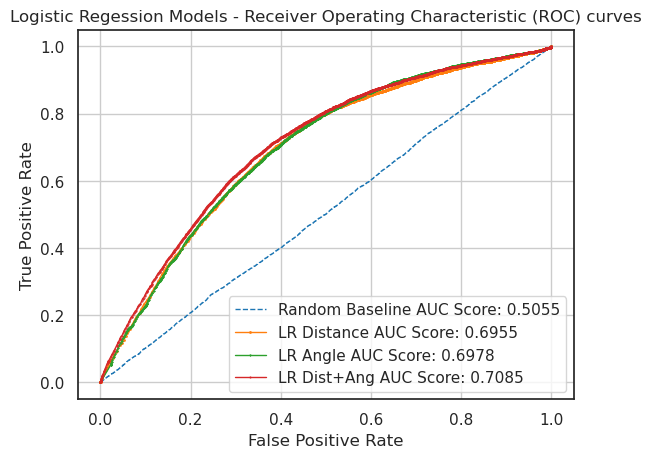

In [184]:
plt.plot(ns_fpr, ns_tpr, linestyle='--',linewidth=1, markersize=1, label=f"Random Baseline AUC Score: {ns_auc}")
plt.plot(lr1_fpr, lr1_tpr, marker='o', linewidth=1, markersize=1,label=f"LR Distance AUC Score: {lr1_auc}")
plt.plot(lr2_fpr, lr2_tpr, marker='*', linewidth=1, markersize=1,label=f"LR Angle AUC Score: {lr2_auc}")
plt.plot(lr3_fpr, lr3_tpr, marker='.', linewidth=1, markersize=1,label=f"LR Dist+Ang AUC Score: {lr3_auc}")
plt.title('Logistic Regession Models - Receiver Operating Characteristic (ROC) curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

### Goal rate (#goals / (#no_goals + #goals)) as a function of the shot probability model percentile

In [185]:
import seaborn as sns
import probscale

In [186]:
df_prob_goals = pd.DataFrame()

In [187]:
df_prob_goals['y_prob_rm'] = ns_probs
df_prob_goals['y_prob_lr1'] = lr1_probs
df_prob_goals['y_prob_lr2'] = lr2_probs
df_prob_goals['y_prob_lr3'] = lr3_probs
df_prob_goals['y_test'] = y_test

In [188]:
df_prob_goals.head()

,y_prob_rm,y_prob_lr1,y_prob_lr2,y_prob_lr3,y_test
0,0.906592,0.189577,0.162324,0.189207,0
1,0.049724,0.033194,0.042055,0.032963,0
2,0.897790,0.090826,0.088594,0.089025,0
3,0.201996,0.105318,0.074529,0.088225,0
4,0.096440,0.154320,0.154565,0.163829,1


In [189]:
d = np.sort(df_prob_goals['y_prob_rm'])
d1 = np.sort(df_prob_goals['y_prob_lr1'])
d2 = np.sort(df_prob_goals['y_prob_lr2'])
d3 = np.sort(df_prob_goals['y_prob_lr3'])

# Percentile values
p = np.array([0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0,80.0,90.0,100.0])


perc = np.percentile(d, p)
perc1 = np.percentile(d1, p)
perc2 = np.percentile(d2, p)
perc3 = np.percentile(d3, p)

In [205]:
def plot_gr_perc():
    x = pd.cut(df_prob_goals[df_prob_goals['y_test'] == 1]['y_prob_rm'], bins=perc).reset_index()
    x =x.groupby('y_prob_rm', as_index=False).size()
    x.columns = ['y_prob_rm', 'count']

    y = pd.cut(df_prob_goals['y_prob_rm'], bins=perc).reset_index()
    y =y.groupby('y_prob_rm', as_index=False).size()
    y.columns = ['y_prob_rm', 'count']

    x1 = pd.cut(df_prob_goals[df_prob_goals['y_test'] == 1]['y_prob_lr1'], bins=perc1).reset_index()
    x1 =x1.groupby('y_prob_lr1', as_index=False).size()
    x1.columns = ['y_prob_lr1', 'count']

    y1 = pd.cut(df_prob_goals['y_prob_lr1'], bins=perc1).reset_index()
    y1 =y1.groupby('y_prob_lr1', as_index=False).size()
    y1.columns = ['y_prob_lr1', 'count']

    x2 = pd.cut(df_prob_goals[df_prob_goals['y_test'] == 1]['y_prob_lr2'], bins=perc2).reset_index()
    x2 =x2.groupby('y_prob_lr2', as_index=False).size()
    x2.columns = ['y_prob_lr2', 'count']

    y2 = pd.cut(df_prob_goals['y_prob_lr2'], bins=perc2).reset_index()
    y2 =y2.groupby('y_prob_lr2', as_index=False).size()
    y2.columns = ['y_prob_lr2', 'count']

    x3 = pd.cut(df_prob_goals[df_prob_goals['y_test'] == 1]['y_prob_lr3'], bins=perc3).reset_index()
    x3 =x3.groupby('y_prob_lr3', as_index=False).size()
    x3.columns = ['y_prob_lr3', 'count']

    y3 = pd.cut(df_prob_goals['y_prob_lr3'], bins=perc3).reset_index()
    y3 =y3.groupby('y_prob_lr3', as_index=False).size()
    y3.columns = ['y_prob_lr3', 'count']

    sns.set_theme(style="white", palette=None)
    sns.lineplot(x=['10','20','30','40','50','60','70','80','90','100' ], y = 100*(x['count'] / y['count']), label = 'Random Uniform Baseline')
    sns.lineplot(x=['10','20','30','40','50','60','70','80','90','100' ], y = 100*(x1['count'] / y1['count']), label = 'LR Model - Distance')
    sns.lineplot(x=['10','20','30','40','50','60','70','80','90','100' ], y = 100*(x2['count'] / y2['count']), label = 'LR Model - Angle')
    sns.lineplot(x=['10','20','30','40','50','60','70','80','90','100' ], y = 100*(x3['count'] / y3['count']), label = 'LR Model - Dist + Ang')
    plt.title('Shot probabilty model percentile vs goal rate')
    plt.xlabel('Shot probability model percentile')
    plt.ylabel("Goal rate")
    #ax.set_yscale('prob')
    fmt = '%.2f%%' # Format you want the ticks, e.g. '40%'
    yticks = mtick.FormatStrFormatter(fmt)
    plt.gca().yaxis.set_major_formatter(yticks)
    plt.gca().invert_xaxis()
    plt.grid()

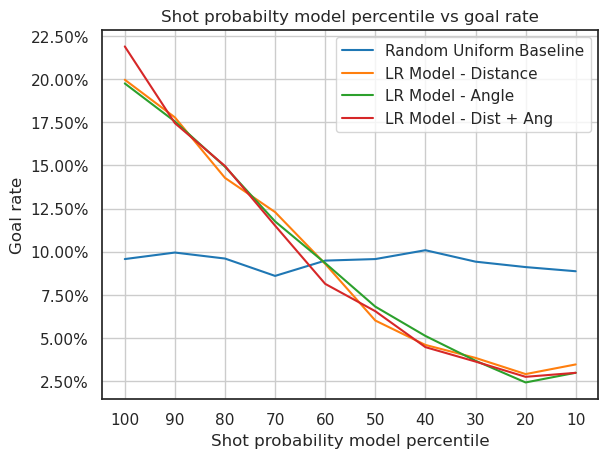

In [206]:
plot_gr_perc()

### Cumulative proportion of goals (not shots) as a function of the shot probability model percentile.

In [192]:
goals = df_prob_goals[df_prob_goals['y_test']==1]

In [193]:
goals

,y_prob_rm,y_prob_lr1,y_prob_lr2,y_prob_lr3,y_test
4,0.096440,0.154320,0.154565,0.163829,1
5,0.009548,0.205681,0.147784,0.188729,1
21,0.544893,0.142821,0.147649,0.152895,1
26,0.039124,0.019325,0.010525,0.011181,1
45,0.451003,0.074433,0.066598,0.067780,1
...,...,...,...,...,...
66477,0.752649,0.053034,0.094716,0.068037,1
66494,0.635254,0.074433,0.066598,0.067780,1
66496,0.380828,0.133782,0.115477,0.128738,1
66515,0.030318,0.079595,0.084418,0.080343,1


In [194]:
d_0 = np.sort(goals['y_prob_rm'])
d_1 = np.sort(goals['y_prob_lr1'])
d_2 = np.sort(goals['y_prob_lr2'])
d_3 = np.sort(goals['y_prob_lr3'])

# Percentile values
p = np.array([0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0,80.0,90.0,100.0])


perc_0 = np.percentile(d_0, p)
perc_1 = np.percentile(d_1, p)
perc_2 = np.percentile(d_2, p)
perc_3 = np.percentile(d_3, p)

In [195]:
def plot_partition_perc():
    x = pd.cut(goals['y_prob_rm'], bins=perc_0).reset_index()
    x =x.groupby('y_prob_rm', as_index=False).size()
    x.columns = ['y_prob_rm', 'count']

    x1 = pd.cut(goals['y_prob_lr1'], bins=perc_1).reset_index()
    x1 =x1.groupby('y_prob_lr1', as_index=False).size()
    x1.columns = ['y_prob_lr1', 'count']

    x2 = pd.cut(goals['y_prob_lr2'], bins=perc_2).reset_index()
    x2 =x2.groupby('y_prob_lr2', as_index=False).size()
    x2.columns = ['y_prob_lr2', 'count']


    x3 = pd.cut(goals['y_prob_lr3'], bins=perc_3).reset_index()
    x3 =x3.groupby('y_prob_lr3', as_index=False).size()
    x3.columns = ['y_prob_lr3', 'count']

    z = len(goals['y_test'])

    sns.set_theme(style="white", palette=None)
    sns.lineplot(x=100*np.flip(perc_0[1:]), y = 100*(np.flip((x['count']/z))).cumsum(), label = 'Random Uniform Baseline')
    sns.lineplot(x=100*np.flip(perc_1[1:]), y = 100*(np.flip((x1['count']/z))).cumsum(), label = 'LR Model - Distance')
    sns.lineplot(x=100*np.flip(perc_2[1:]), y = 100*(np.flip((x2['count']/z))).cumsum(), label = 'LR Model - Angle')
    sns.lineplot(x=100*np.flip(perc_3[1:]), y = 100*(np.flip((x3['count']/z))).cumsum(), label = 'LR Model - Dist + Ang')
    plt.title('Shot probabilty model percentile vs goal rate')
    plt.xlabel('Shot probability model percentile')
    plt.ylabel("Proportion")
    #plt.yscale('log')
    fmt = '%.2f%%' # Format you want the ticks, e.g. '40%'
    yticks = mtick.FormatStrFormatter(fmt)
    plt.gca().yaxis.set_major_formatter(yticks)
    xticks = mtick.FormatStrFormatter(fmt)
    plt.gca().xaxis.set_major_formatter(xticks)
    plt.gca().invert_xaxis()
    plt.grid()

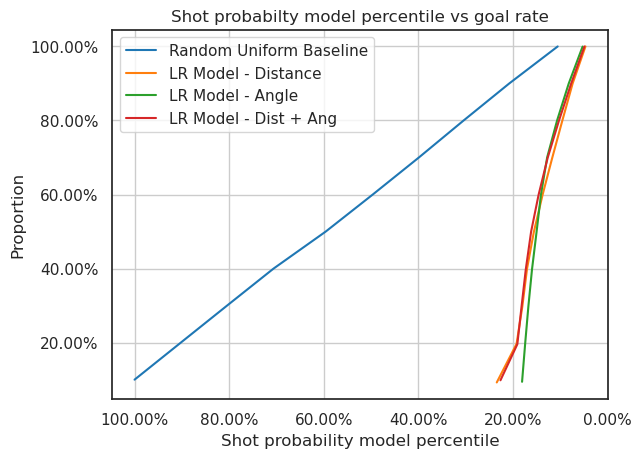

In [196]:
plot_partition_perc()

### Calibration Plot

In [197]:
from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import calibration_curve
import matplotlib.transforms as mtransforms
from matplotlib.gridspec import GridSpec

In [198]:
logreg1_y, logreg1_x = calibration_curve(y_test, lr1_probs, n_bins=20)
logreg2_y, logreg2_x = calibration_curve(y_test, lr2_probs, n_bins=20)
logreg3_y, logreg3_x = calibration_curve(y_test, lr3_probs, n_bins=20)
rc_y, rc_x = calibration_curve(y_test, ns_probs, n_bins=20)

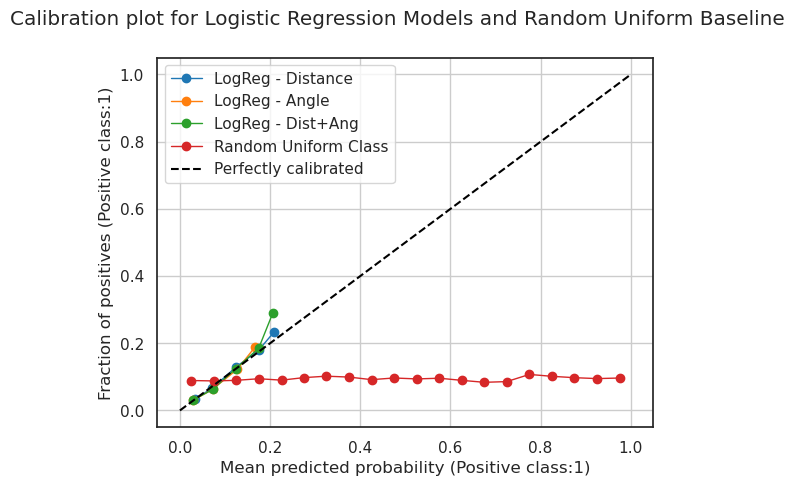

In [199]:
fig, ax = plt.subplots()
# only these two lines are calibration curves
plt.plot(logreg1_x,logreg1_y, marker='o', linewidth=1, label='LogReg - Distance')
plt.plot(logreg2_x,logreg2_y, marker='o', linewidth=1, label='LogReg - Angle')
plt.plot(logreg3_x,logreg3_y, marker='o', linewidth=1, label='LogReg - Dist+Ang')
plt.plot(rc_x, rc_y, marker='o', linewidth=1, label='Random Uniform Class')

# reference line, legends, and axis labels
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Perfectly calibrated')
fig.suptitle('Calibration plot for Logistic Regression Models and Random Uniform Baseline')
ax.set_xlabel('Mean predicted probability (Positive class:1)')
ax.set_ylabel('Fraction of positives (Positive class:1)')
plt.grid()
plt.legend()
plt.show()

In [202]:
#experiment.end()